In [3]:
from google.colab import files
uploaded = files.upload()

Saving new_data.csv to new_data.csv


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
df = pd.read_csv("new_data.csv")
df

,lap_id,invalid_lap,BPS_SPEED,BPS_THROTTLE,BPS_STEER,BPS_BRAKE,BPS_LAPDISTANCE,BPS_WORLDPOSITIONX,BPS_WORLDPOSITIONY,BPS_WORLDFORWARDDIRX,...,APX2_YAW,APX2_PITCH,APX2_ROLL,APX2_left_dist,APX2_dist_apex_1,APX2_dist_apex_2,APX2_angle_to_apex1,APX2_angle_to_apex2,APX2_proj_from_ref,Target_CURRENTLAPTIMEINMS
0,10021698834789871149_1,1,316.0,1.000000,0.074568,0.0,223.0,274.071987,313.458779,-23579.0,...,-2.906792,0.002597,-0.015706,1.188303,101.216786,1.468423,176.387023,-73.297876,1.243211,15377
1,10021698834789871149_10,1,324.0,0.970802,0.000464,0.0,273.0,310.096901,278.846172,-23824.0,...,-2.975512,-0.004548,-0.010439,1.716472,101.368594,0.941933,178.312192,-68.980181,0.715854,12146
2,10021698834789871149_11,1,322.0,1.000000,-0.002375,0.0,258.0,298.743940,288.688005,-23746.0,...,-2.922204,-0.003019,-0.011373,2.731520,101.668646,0.122973,176.987177,53.851467,0.297512,12220
3,10021698834789871149_12,0,322.0,0.025177,0.006011,0.0,269.0,307.165908,281.569461,-23818.0,...,-2.923212,-0.002735,-0.009557,1.879479,101.417020,0.779785,177.377583,-68.683995,0.553155,12219
4,10021698834789871149_13,1,324.0,1.000000,0.021114,0.0,268.0,306.397540,282.215448,-23831.0,...,-2.824224,0.006822,-0.014098,4.818916,102.315233,2.167787,173.829692,99.915419,2.381417,12881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,9874269645241895165_2,1,144.0,0.000000,-0.525250,0.0,450.0,369.369267,134.915112,5165.0,...,-2.974651,-0.000140,-0.022406,2.409240,105.101572,7.066486,179.753790,-120.396863,5.033546,13686
821,9941972541231747669_1,1,324.0,1.000000,0.000000,0.0,263.0,302.615240,285.497492,-23572.0,...,-2.875317,-0.000517,-0.010140,1.617995,101.340908,1.039864,176.906931,-71.039304,0.814210,12490
822,9941972541231747669_2,0,324.0,1.000000,-0.000000,0.0,264.0,303.184481,284.646456,-23649.0,...,-2.914761,-0.002244,-0.008611,1.437935,101.289007,1.219306,177.457928,-71.360891,0.993987,12326
823,9948558370850722411_1,1,324.0,1.000000,-0.003344,0.0,276.0,301.987594,286.287858,-24030.0,...,-2.907833,0.001437,-0.014618,2.980371,101.744896,0.340118,175.711551,87.320007,0.545892,13604


R² Score: 0.403
RMSE: 3785.104 ms


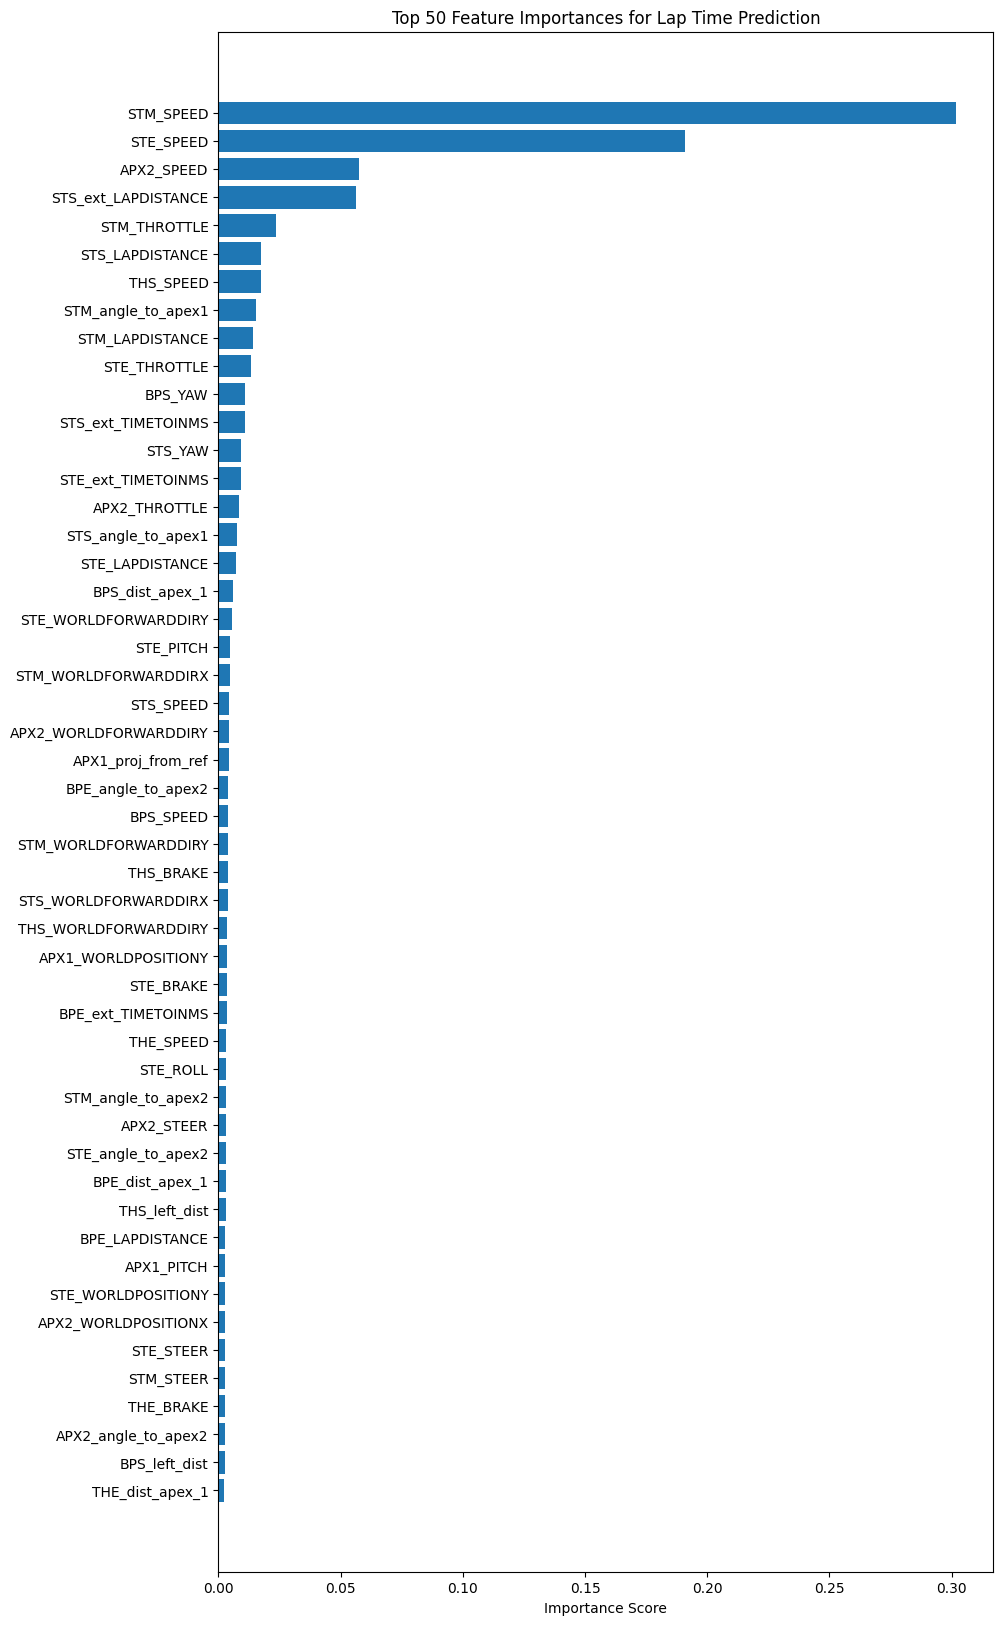

In [5]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

target = "Target_CURRENTLAPTIMEINMS"

# Drop 'lap_id' and 'invalid_lap' as they are not numeric and not suitable for the model
X = df.drop(columns=["lap_id", "invalid_lap", target], errors="ignore")
y = df[target]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define and train XGBoost model
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:gamma"
    # used gamma for now but can potentially log-transform the target and revert back to reg:squarederror
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f} ms")

# Feature importance plot
plt.figure(figsize=(10, 20))
importance = model.feature_importances_
sorted_idx = np.argsort(importance)[-50:]
plt.barh(X.columns[sorted_idx], importance[sorted_idx])
plt.title("Top 50 Feature Importances for Lap Time Prediction")
plt.xlabel("Importance Score")
plt.show()

In [ ]:
importance = model.feature_importances_
importance_series = pd.Series(importance, index=X.columns).sort_values(ascending=False)

top50 = importance_series.head(50)
print(top50)


STM_SPEED                0.301934
STE_SPEED                0.190716
APX2_SPEED               0.057605
STS_ext_LAPDISTANCE      0.056495
STM_THROTTLE             0.023753
STS_LAPDISTANCE          0.017471
THS_SPEED                0.017252
STM_angle_to_apex1       0.015507
STM_LAPDISTANCE          0.013977
STE_THROTTLE             0.013225
BPS_YAW                  0.011012
STS_ext_TIMETOINMS       0.011003
STS_YAW                  0.009421
STE_ext_TIMETOINMS       0.009399
APX2_THROTTLE            0.008451
STS_angle_to_apex1       0.007747
STE_LAPDISTANCE          0.007260
BPS_dist_apex_1          0.005895
STE_WORLDFORWARDDIRY     0.005391
STE_PITCH                0.004779
STM_WORLDFORWARDDIRX     0.004589
STS_SPEED                0.004516
APX2_WORLDFORWARDDIRY    0.004504
APX1_proj_from_ref       0.004248
BPE_angle_to_apex2       0.004138
BPS_SPEED                0.003990
STM_WORLDFORWARDDIRY     0.003845
THS_BRAKE                0.003837
STS_WORLDFORWARDDIRX     0.003762
THS_WORLDFORWA

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    "n_estimators": randint(100, 700),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.1),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3)
}

rand = RandomizedSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)
rand.fit(X, y)

print("Best parameters:", rand.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'colsample_bytree': np.float64(0.7595329043944331), 'learning_rate': np.float64(0.0899283318459481), 'max_depth': 6, 'n_estimators': 208, 'subsample': np.float64(0.7432483832562453)}


In [1]:
mutual = ["APX2_SPEED", "STE_SPEED", "STM_SPEED", "THE_SPEED", "THS_SPEED", "BPS_SPEED",
          "APX1_SPEED", "APX1_YAW", "STE_THROTTLE", "APX2_WORLDFORWARDDIRY", "APX2_PITCH",
          "APX1_WORLDFORWARDDIRX", "THE_ext_TIMETOINMS", "THE_ext_LAPDISTANCE", "BPE_SPEED",
          "STS_ext_LAPDISTANCE", "STM_WORLDPOSITIONY", "STE_angle_to_apex2", "STM_THROTTLE"
          "STE_LAPDISTANCE", "APX2_THROTTLE", "STS_SPEED", "APX1_proj_from_ref",
          "STM_dist_apex_1", "STE_angle_to_apex1", "THE_LAPDISTANCE", "STM_LAPDISTANCE"
          "BPS_left_dist", "STE_WORLDFORWARDDIRX", "STE_PITCH", "APX1_left_dist",
          "STS_left_dist", "STS_dist_apex_2", "BPS_ROLL", "STS_WORLDPOSITIONY", "STM_WORLDPOSITIONX"
          "THS_PITCH", "STS_BRAKE", "STM_YAW", "STE_WORLDFORWARDDIRY", "THS_WORLDFORWARDDIRY", "STS_ext_TIMETOINMS"
          "APX1_WORLDPOSITIONX", "THE_YAW", "STE_ROLL", "STS_proj_from_ref", "THE_WORLDFORWARDDIRX", "STM_WORLDFORWARDDIRX"
          "STE_YAW", "STE_WORLDPOSITION"]

info_gain = ["APX2_SPEED", "THS_SPEED", "BPS_SPEED", "STM_SPEED", "APX1_SPEED",
             "BPE_angle_to_apex2", "THE_ext_TIMETOINMS", "STE_proj_from_ref",
             "THE_SPEED", "THS_ext_LAPDISTANCE", "APX2_STEER", "BPS_left_dist",
             "BPS_ext_TIMETOINMS", "STM_ROLL", "STS_SPEED", "STE_STEER", "BPS_STEER",
             "THS_WORLDPOSITIONY", "THS_proj_from_ref", "STM_LAPDISTANCE", "APX2_angle_to_apex1",
             "THE_ext_LAPDISTANCE", "BPE_left_dist", "BPE_WORLDFORWARDDIRY", "THE_dist_apex_2",
             "STM_WORLDPOSITIONX", "APX2_angle_to_apex2", "THS_STEER", "THS_THROTTLE",
             "THE_proj_from_ref", "BPS_WORLDPOSITIONX", "APX1_STEER"]

elastic = ["THE_BRAKE", "STM_BRAKE", "BPE_ROLL", "STM_ROLL", "BPS_SPEED", "THE_SPEED", "STM_SPEED", "STE_SPEED",
           "APX2_SPEED", "BPS_STEER", "STS_STEER", "STM_STEER", "APX1_SPEED", "APX2_SPEED", "STS_THROTTLE", "STM_THROTTLE", "STE_THROTTLE"
           "THS_WORLDFORWARDDIRX", "APX2_WORLDFORWARDDIRY", "STM_WORLDPOSITIONX", "APX1_WORLDPOSITIONY", "BPE_YAW", "THS_YAW", "STS_YAW"
           "APX2_YAW", "BPE_angle_to_apex1", "STS_angle_to_apex1", "APX2_angle_to_apex1", "STS_angle_to_apex2", "STM_angle_to_apex2"
           "STE_angle_to_apex2", "BPE_dist_apex_1", "THE_dist_apex_1", "STM_dist_apex_1", "STE_dist_apex_1", "THS_ext_LAPDISTANCE",
           "THE_ext_LAPDISTANCE", "STE_ext_LAPDISTANCE", "BPS_ext_TIMETOINMS", "THS_ext_TIMETOINMS", "THE_ext_TIMETOINMS", "STS_ext_TIMETOINMS",
           "STE_ext_TIMETOINMS", "STS_left_dist", "STM_left_dist", "BPE_proj_from_ref"]

xgboost = ["STM_SPEED", "STE_SPEED", "STS_ext_LAPDISTANCE", "APX2_SPEED", "BPS_YAW", "STM_THROTTLE", "STS_LAPDISTANCE", "STS_LAPDISTANCE",
           "STM_WORLDFORWARDDIRX", "BPE_angle_to_apex2", "APX2_angle_to_apex2", "APX2_dist_apex_1", "STE_WORLDFORWARDDIRY",
           "STS_ext_TIMETOINMS", "STM_WORLDFORWARDDIRY", "STE_THROTTLE", "STM_angle_to_apex1", "APX2_WORLDFORWARDDIRY", "STS_SPEED", "THS_SPEED"
           "APX1_left_dist", "STE_ext_TIMETOINMS", "THS_WORLDFORWARDDIRY", "THS_ext_LAPDISTANCE", "STS_YAW", "APX1_dist_apex_1", "STM_BRAKE",
           "THS_ROLL", "STS_angle_to_apex1", "THS_proj_from_ref", "STE_YAW", "APX1_angle_to_apex2", "STM_ROLL", "STE_LAPDISTANCE",
           "THE_ext_TIMETOINMS", "BPS_THROTTLE", "APX1_WORLDPOSITIONX", "APX2_WORLDPOSITIONY", "BPS_left_dist", "BPE_LAPDISTANCE",
           "BPS_angle_to_apex1", "APX2_PITCH", "BPE_STEER", "APX2_YAW", "THS_WORLDFORWARDDIRX", "STS_WORLDFORWARDDIRY", "STE_PITCH",
           "STS_PITCH", "APX1_STEER", "BPE_WORLDFORWARDDIRX", "THS_STEER"]

random_forest = ["STM_SPEED", "STE_SPEED", "APX2_SPEED", "STS_angle_to_apex1", "STS_YAW", "STM_angle_to_apex1", "STE_ext_TIMETOINMS",
                 "THE_ext_TIMETOINMS", "THS_SPEED", "BPS_SPEED", "STM_WORLDFORWARDDIRX", "APX2_PITCH", "STM_WORLDFORWARDDIRY",
                 "STE_WORLDFORWARDDIRY", "THE_WORLDFORWARDDIRX", "BPE_YAW", "APX2_angle_to_apex2", "THS_STEER", "THE_ext_LAPDISTANCE",
                 "STS_SPEED", "STM_YAW", "STE_PITCH", "STE_WORLDFORWARDDIRX", "THE_dist_apex_1", "THS_proj_from_ref", "BPS_YAW",
                 "THE_ROLL", "BPE_WORLDFORWARDDIRY", "BPS_THROTTLE", "APX1_SPEED", "THE_SPEED", "APX2_STEER", "BPS_PITCH", "APX1_BRAKE",
                 "STS_WORLDPOSITIONX", "BPE_ext_TIMETOINMS", "THS_PITCH", "STS_WORLDFORWARDDIRX", "THS_ext_TIMETOINMS"]


In [2]:
union = set(mutual) | set(xgboost) | set(random_forest) | set(elastic) | set(info_gain)
print(sorted(union))

['APX1_BRAKE', 'APX1_SPEED', 'APX1_STEER', 'APX1_WORLDFORWARDDIRX', 'APX1_WORLDPOSITIONX', 'APX1_WORLDPOSITIONY', 'APX1_YAW', 'APX1_angle_to_apex2', 'APX1_dist_apex_1', 'APX1_left_dist', 'APX1_proj_from_ref', 'APX2_PITCH', 'APX2_SPEED', 'APX2_STEER', 'APX2_THROTTLE', 'APX2_WORLDFORWARDDIRY', 'APX2_WORLDPOSITIONY', 'APX2_YAW', 'APX2_angle_to_apex1', 'APX2_angle_to_apex2', 'APX2_dist_apex_1', 'BPE_LAPDISTANCE', 'BPE_ROLL', 'BPE_SPEED', 'BPE_STEER', 'BPE_WORLDFORWARDDIRX', 'BPE_WORLDFORWARDDIRY', 'BPE_YAW', 'BPE_angle_to_apex1', 'BPE_angle_to_apex2', 'BPE_dist_apex_1', 'BPE_ext_TIMETOINMS', 'BPE_left_dist', 'BPE_proj_from_ref', 'BPS_PITCH', 'BPS_ROLL', 'BPS_SPEED', 'BPS_STEER', 'BPS_THROTTLE', 'BPS_WORLDPOSITIONX', 'BPS_YAW', 'BPS_angle_to_apex1', 'BPS_ext_TIMETOINMS', 'BPS_left_dist', 'STE_LAPDISTANCE', 'STE_PITCH', 'STE_ROLL', 'STE_SPEED', 'STE_STEER', 'STE_THROTTLE', 'STE_THROTTLETHS_WORLDFORWARDDIRX', 'STE_WORLDFORWARDDIRX', 'STE_WORLDFORWARDDIRY', 'STE_WORLDPOSITION', 'STE_YAW', 'STE

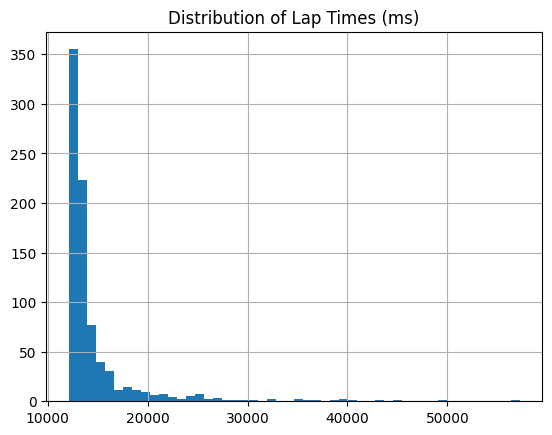

In [ ]:
import matplotlib.pyplot as plt
y.hist(bins=50)
plt.title("Distribution of Lap Times (ms)")
plt.show()

    SquareError:  R²=0.423,  RMSE=3721.20 ms
          Gamma:  R²=0.403,  RMSE=3785.10 ms
Log-SquareError:  R²=0.413,  RMSE=3755.38 ms


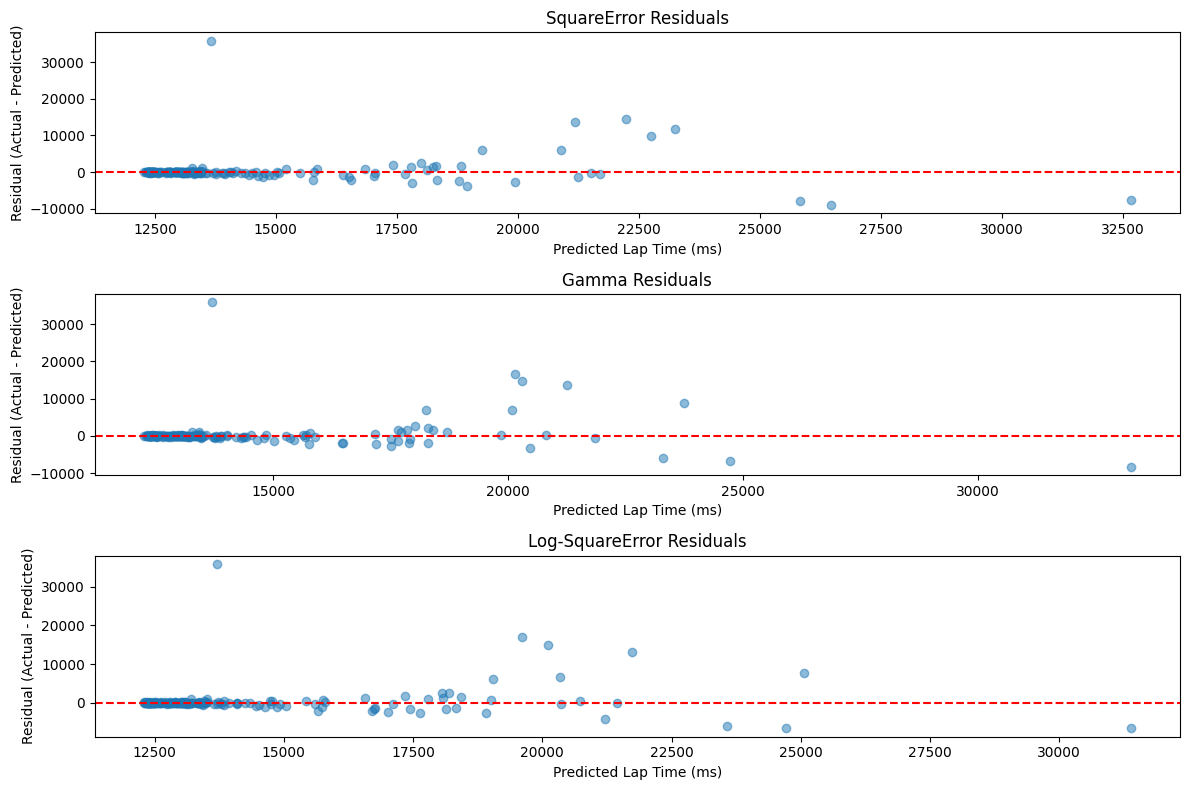

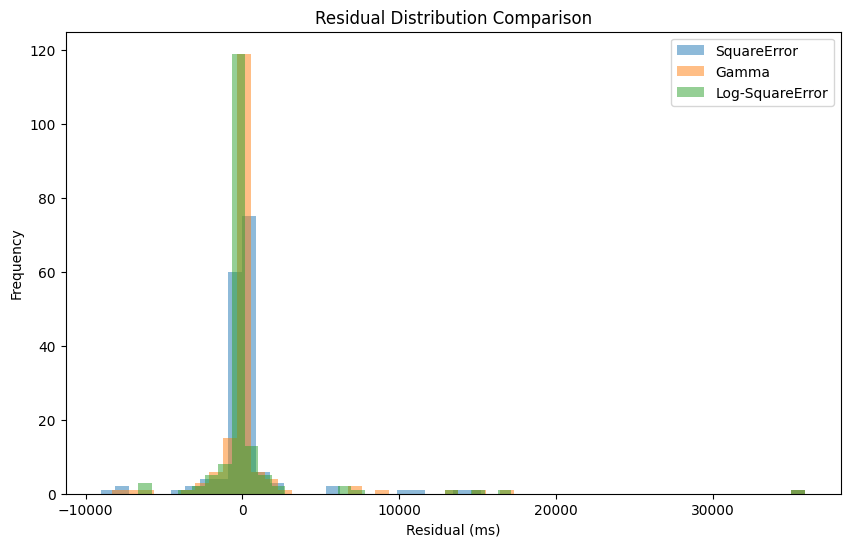

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standard reg:squarederror
m1 = XGBRegressor(objective="reg:squarederror",
                  n_estimators=400, learning_rate=0.05, max_depth=6,
                  subsample=0.8, colsample_bytree=0.8, random_state=42)
m1.fit(X_train, y_train)
pred1 = m1.predict(X_test)

# reg: gamma
m2 = XGBRegressor(objective="reg:gamma",
                  n_estimators=400, learning_rate=0.05, max_depth=6,
                  subsample=0.8, colsample_bytree=0.8, random_state=42)
m2.fit(X_train, y_train)
pred2 = m2.predict(X_test)

# Log-transform + reg:squarederror
y_train_log = np.log1p(y_train)
m3 = XGBRegressor(objective="reg:squarederror",
                  n_estimators=400, learning_rate=0.05, max_depth=6,
                  subsample=0.8, colsample_bytree=0.8, random_state=42)
m3.fit(X_train, y_train_log)
pred3 = np.expm1(m3.predict(X_test))

# evaluation of all 3
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

models = {
    "SquareError": (y_test, pred1),
    "Gamma": (y_test, pred2),
    "Log-SquareError": (y_test, pred3)
}

results = {}
for name, (yt, yp) in models.items():
    rmse, r2 = evaluate(yt, yp)
    results[name] = (rmse, r2)
    print(f"{name:>15}:  R²={r2:.3f},  RMSE={rmse:.2f} ms")

# residual plots
plt.figure(figsize=(12, 8))
for i, (name, (yt, yp)) in enumerate(models.items(), start=1):
    residuals = yt - yp
    plt.subplot(3, 1, i)
    plt.scatter(yp, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"{name} Residuals")
    plt.xlabel("Predicted Lap Time (ms)")
    plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

# Residual distribution comparison
plt.figure(figsize=(10,6))
for name, (yt, yp) in models.items():
    residuals = yt - yp
    plt.hist(residuals, bins=50, alpha=0.5, label=name)
plt.title("Residual Distribution Comparison")
plt.xlabel("Residual (ms)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


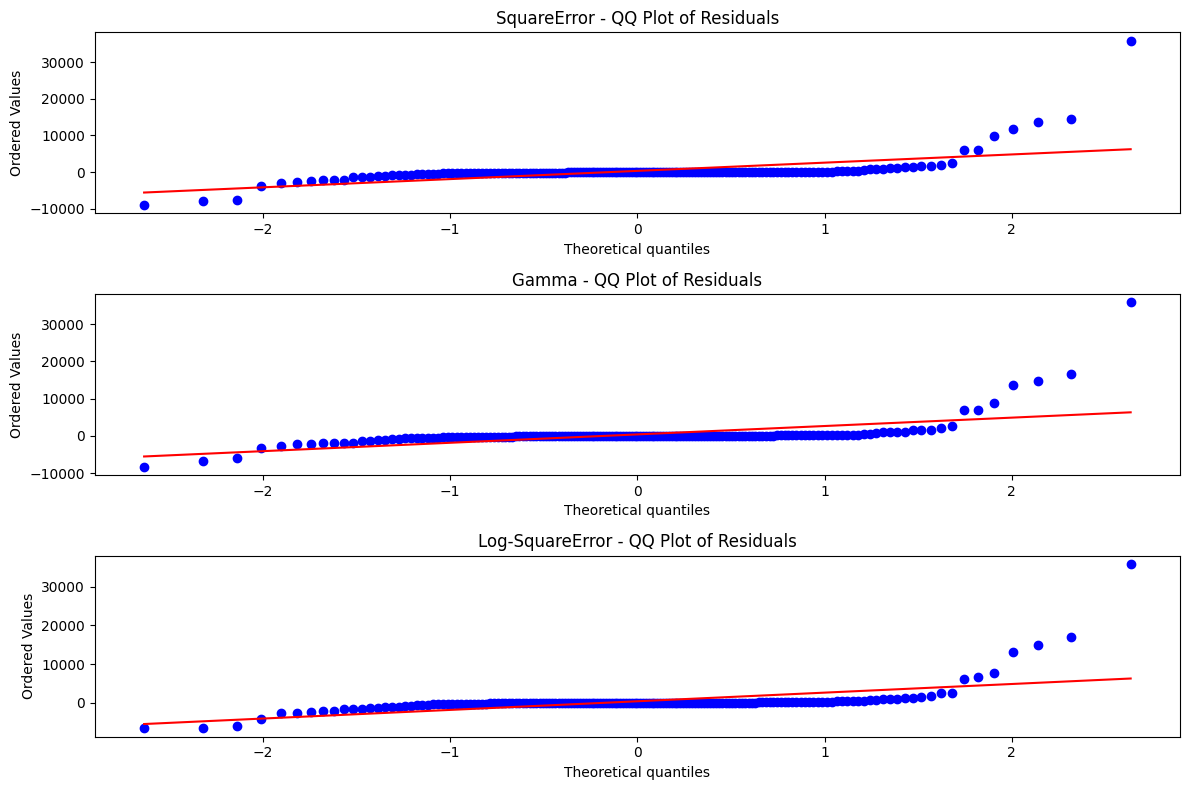

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, (name, (yt, yp)) in enumerate(models.items(), start=1):
    residuals = yt - yp
    plt.subplot(3, 1, i)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"{name} - QQ Plot of Residuals")

plt.tight_layout()
plt.show()


R² Score: 0.404
RMSE: 3782.341 ms


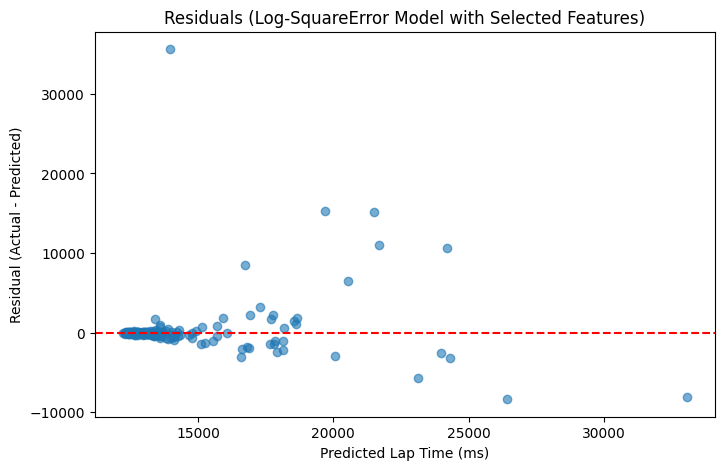

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

selected_features = ["APX1_BRAKE", "APX1_SPEED", "APX1_STEER", "APX1_WORLDFORWARDDIRX",
    "APX1_YAW", "APX1_angle_to_apex2", "APX1_proj_from_ref", "APX2_SPEED",
    "APX2_STEER", "APX2_THROTTLE", "APX2_WORLDPOSITIONY", "APX2_angle_to_apex1",
    "APX2_angle_to_apex2", "APX2_dist_apex_1", "BPE_ROLL", "BPE_STEER",
    "BPE_WORLDFORWARDDIRY", "BPE_YAW", "BPE_angle_to_apex1", "BPE_angle_to_apex2",
    "BPE_ext_TIMETOINMS", "BPE_left_dist", "BPE_proj_from_ref", "BPS_PITCH",
    "BPS_ROLL", "BPS_STEER", "BPS_THROTTLE", "BPS_YAW",
    "BPS_angle_to_apex1", "BPS_ext_TIMETOINMS", "STE_ROLL", "STE_STEER",
    "STE_THROTTLE", "STE_angle_to_apex1", "STE_ext_LAPDISTANCE", "STE_ext_TIMETOINMS",
    "STE_proj_from_ref", "STM_BRAKE", "STM_ROLL", "STM_SPEED",
    "STM_STEER", "STM_WORLDFORWARDDIRY", "STM_YAW", "STM_angle_to_apex1",
    "STM_angle_to_apex2", "STM_left_dist", "STS_BRAKE", "STS_STEER",
    "STS_THROTTLE", "STS_angle_to_apex1", "STS_angle_to_apex2", "STS_ext_TIMETOINMS",
    "STS_proj_from_ref", "THE_BRAKE", "THE_ROLL", "THE_SPEED",
    "THE_WORLDFORWARDDIRX", "THE_YAW", "THE_dist_apex_1", "THE_proj_from_ref",
    "THS_ROLL", "THS_STEER", "THS_THROTTLE", "THS_YAW",
    "THS_proj_from_ref"]

# Data preparation
X = df[selected_features]
y = df["Target_CURRENTLAPTIMEINMS"]

# Log-transformation to stabilize variance
y_log = np.log1p(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Model training
model = XGBRegressor(
    objective="reg:squarederror",  # can go back to reg:gamma depending on model performance
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
model.fit(X_train, y_train)

# Predict and reverse log transformation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Evaluation metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f} ms")

# Residual plots
residuals = y_true - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals (Log-SquareError Model with Selected Features)")
plt.xlabel("Predicted Lap Time (ms)")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()
